# Broadcast Graphs

In [1]:
# Load modules
from utils import *
from epyc import *
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd
import os

# Current working directory
cwd = os.getcwd()

# Broadcast data
node_file = os.path.join(cwd, '../datasets/bcast_node.csv')
socket_file = os.path.join(cwd, '../datasets/bcast_socket.csv')
core_file = os.path.join(cwd, '../datasets/bcast_core.csv')

# Create the node objects
node1 = Node()
node2 = Node()

# Function to compute R^2
from sklearn.metrics import r2_score
import numpy as np
def compute_r_squared(predicted, measured):
    # Ensure the inputs are numpy arrays
    predicted = np.array(predicted)
    measured = np.array(measured)

    # Compute R squared
    r_squared = r2_score(measured, predicted)

    return r_squared

## Default

In [29]:
# Loading datasets -------------------------------------------------------------
dfn0 = preproc(node_file, 'node', 0)
dfs0 = preproc(socket_file, 'socket', 0)
dfc0 = preproc(core_file, 'core', 0)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn0 = dfn0[dfn0['size']==sizestop]
dfs0 = dfs0[dfs0['size']==sizestop]
dfc0 = dfc0[dfc0['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs0 = dfs0[~((dfs0['size']<=64) & (dfs0['latency']>20))]
dfc0 = dfc0[~((dfc0['size']<=64) & (dfc0['latency']>8))]

# Add dummy variables ----------------------------------------------------------

# Core dataset
dfc0['group'] = pd.cut(dfc0['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc0['group'] = dfc0['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc0['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc0 = pd.concat([dfc0, group_dummies], axis=1)

# Create interaction terms with the cores
dfc0['cores_group2'] = dfc0['cores'] * dfc0['group_socket2']
dfc0['cores_group3'] = dfc0['cores'] * dfc0['group_socket3']
dfc0['cores_group4'] = dfc0['cores'] * dfc0['group_socket4']

# Socket dataset
dfs0['group'] = pd.cut(dfs0['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs0['group'] = dfs0['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs0['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs0 = pd.concat([dfs0, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs0['cores_group1'] = dfs0['cores'] * dfs0['group_node1']
dfs0['cores_group2'] = dfs0['cores'] * dfs0['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc0['latency']
X = dfc0[['cores', 
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs0['latency']
X = dfs0[['cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn0['latency']
X = dfn0[['cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['cores'] + beta['core']['cores_group2']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores']*p)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p)
    else:
        return (beta['node']['const'] + beta['node']['cores'] * p)

R-squared for core: 0.9238226818750188
R-squared for socket: 0.9010989532998015
R-squared for node: 0.8993704808301185


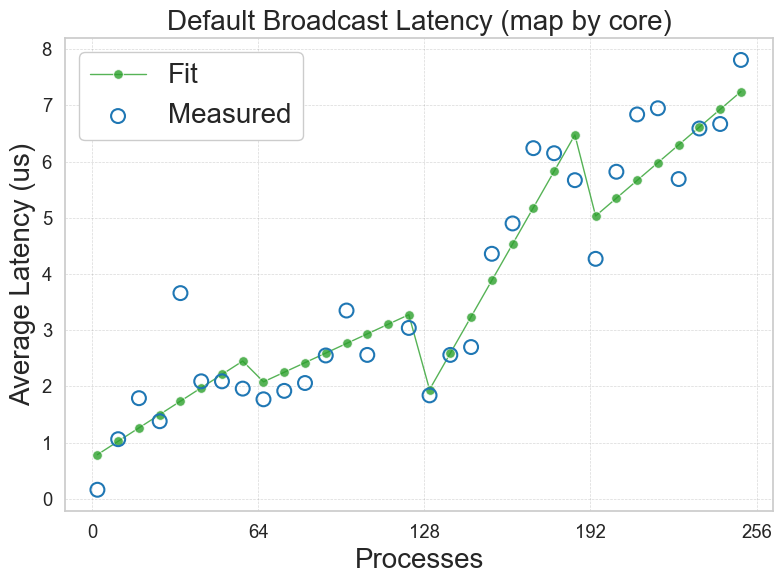

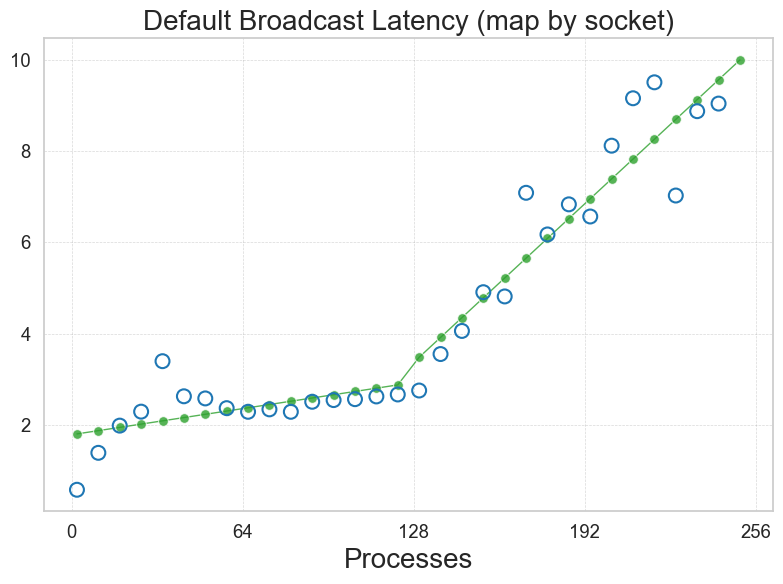

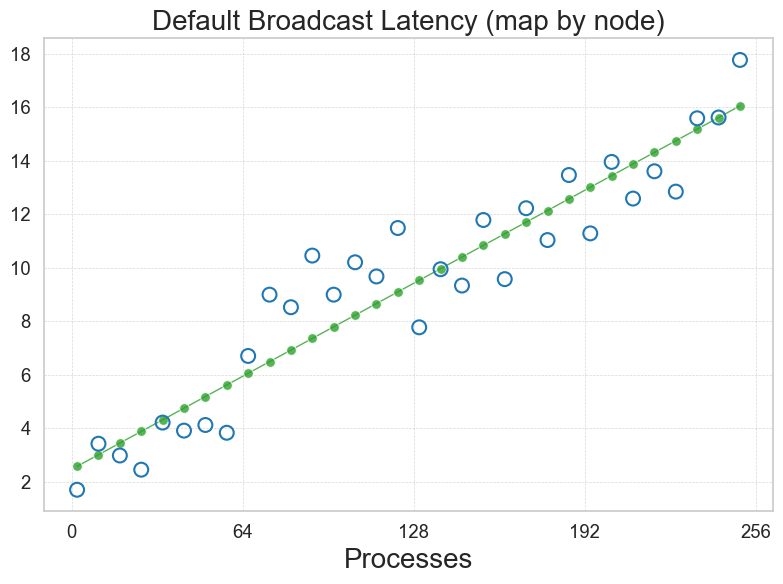

In [30]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65

# Compute the R^2 for the Model
# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")

# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc0 = dfc0[dfc0['cores'].isin(x)]
dfc0 = dfc0.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
plt.scatter(x=dfc0['cores'], y=dfc0['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Default Broadcast Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-default-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs0 = dfs0[dfs0['cores'].isin(x)]
dfs0 = dfs0.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
plt.scatter(x=dfs0['cores'], y=dfs0['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Default Broadcast Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-default-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn0 = dfn0[dfn0['cores'].isin(x)]
dfn0 = dfn0.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
plt.scatter(x=dfn0['cores'], y=dfn0['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Default Broadcast Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-default-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Linear

In [11]:
# Loading datasets -------------------------------------------------------------
dfn1 = preproc(node_file, 'node', 1)
dfs1 = preproc(socket_file, 'socket', 1)
dfc1 = preproc(core_file, 'core', 1)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn1 = dfn1[dfn1['size']==sizestop]
dfs1 = dfs1[dfs1['size']==sizestop]
dfc1 = dfc1[dfc1['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs1 = dfs1[~((dfs1['size']<=64) & (dfs1['latency']>50))]

# Add dummy variables ----------------------------------------------------------

# Core dataset
dfc1['group'] = pd.cut(dfc1['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc1['group'] = dfc1['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc1['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc1 = pd.concat([dfc1, group_dummies], axis=1)

# Create interaction terms with the cores
dfc1['cores_group2'] = dfc1['cores'] * dfc1['group_socket2']
dfc1['cores_group3'] = dfc1['cores'] * dfc1['group_socket3']
dfc1['cores_group4'] = dfc1['cores'] * dfc1['group_socket4']

# Socket dataset
dfs1['group'] = pd.cut(dfs1['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs1['group'] = dfs1['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs1['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs1 = pd.concat([dfs1, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs1['cores_group1'] = dfs1['cores'] * dfs1['group_node1']
dfs1['cores_group2'] = dfs1['cores'] * dfs1['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc1['latency']
X = dfc1[['cores', 
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs1['latency']
X = dfs1[['cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn1['latency']
X = dfn1[['cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['cores'] + beta['core']['cores_group2']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores']*p)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p)
    else:
        return (beta['node']['const'] + beta['node']['cores'] * p)

R-squared for core: 0.9298058596290554
R-squared for socket: 0.9862163564397721
R-squared for node: 0.9162742713259941
R-squared for core: 0.9959168804715433
R-squared for socket: 0.9966374758980233
R-squared for node: 0.9955023668282625


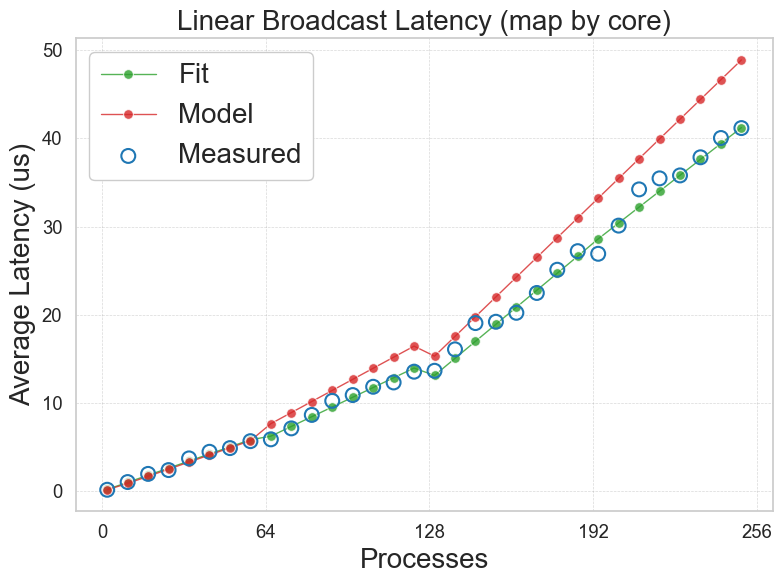

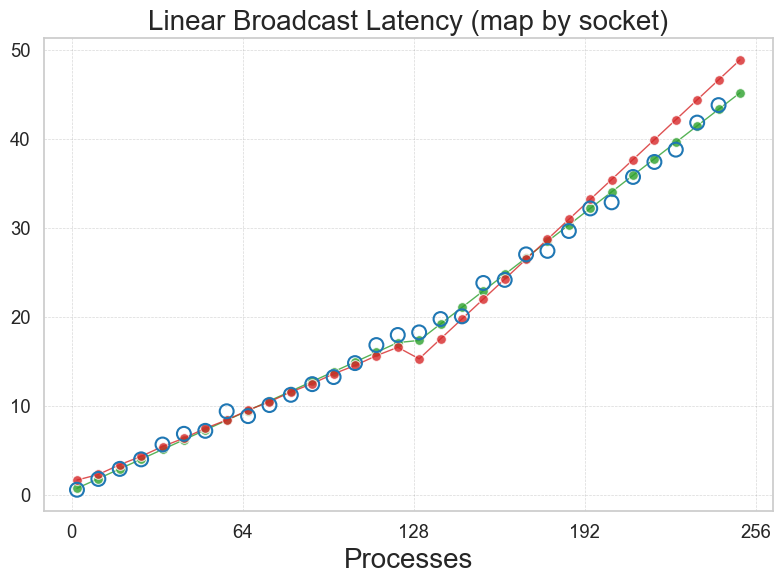

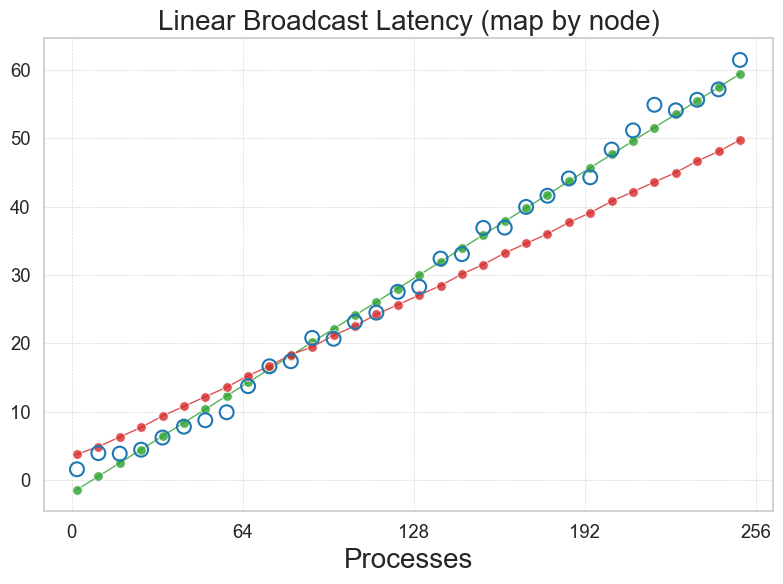

In [12]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65

# R2 ---------------------------------------------------------------------------

# Compute the R^2 for the Model
# Core
x = dfc1['cores']
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [linear_bcast(p[:core], sizestop) for core in x]
r_squared = compute_r_squared(y_m, dfc1['latency'])
print(f"R-squared for core: {r_squared}")

# Socket
x = dfs1['cores']
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [linear_bcast(p[:core], sizestop) for core in x]
r_squared = compute_r_squared(y_m, dfs1['latency'])
print(f"R-squared for socket: {r_squared}")

# Node
x = dfn1['cores']
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [linear_bcast(p[:core], sizestop) for core in x]
r_squared = compute_r_squared(y_m, dfn1['latency'])
print(f"R-squared for node: {r_squared}")

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")

# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [linear_bcast(p[:core], sizestop) for core in x]
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc1 = dfc1[dfc1['cores'].isin(x)]
dfc1 = dfc1.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:red', alpha =0.8)
plt.scatter(x=dfc1['cores'], y=dfc1['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Broadcast Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-linear-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [linear_bcast(p[:core], sizestop) for core in x]
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs1 = dfs1[dfs1['cores'].isin(x)]
dfs1 = dfs1.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfs1['cores'], y=dfs1['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Broadcast Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-linear-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [linear_bcast(p[:core], sizestop) for core in x]
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn1 = dfn1[dfn1['cores'].isin(x)]
dfn1 = dfn1.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfn1['cores'], y=dfn1['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Broadcast Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-linear-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Chain

In [13]:
# Loading datasets -------------------------------------------------------------
dfn2 = preproc(node_file, 'node', 2)
dfs2 = preproc(socket_file, 'socket', 2)
dfc2 = preproc(core_file, 'core', 2)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn2 = dfn2[dfn2['size']==sizestop]
dfs2 = dfs2[dfs2['size']==sizestop]
dfc2 = dfc2[dfc2['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs2 = dfs2[~((dfs2['size']<=16) & (dfs2['latency']>60))]
dfc2 = dfc2[~((dfc2['size']<=16) & (dfc2['latency']>30))]

# Add dummy variables ----------------------------------------------------------

# Core dataset
dfc2['group'] = pd.cut(dfc2['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc2['group'] = dfc2['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc2['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc2 = pd.concat([dfc2, group_dummies], axis=1)

# Create interaction terms with the cores
dfc2['cores_group2'] = dfc2['cores'] * dfc2['group_socket2']
dfc2['cores_group3'] = dfc2['cores'] * dfc2['group_socket3']
dfc2['cores_group4'] = dfc2['cores'] * dfc2['group_socket4']

# Socket dataset
dfs2['group'] = pd.cut(dfs2['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs2['group'] = dfs2['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs2['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs2 = pd.concat([dfs2, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs2['cores_group1'] = dfs2['cores'] * dfs2['group_node1']
dfs2['cores_group2'] = dfs2['cores'] * dfs2['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc2['latency']
X = dfc2[['cores', 
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs2['latency']
X = dfs2[['cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn2['latency']
X = dfn2[['cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['cores'] + beta['core']['cores_group2']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores']*p)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p)
    else:
        return (beta['node']['const'] + beta['node']['cores'] * p)

R-squared for core: 0.8392003116014526
R-squared for socket: 0.895506953426346
R-squared for node: 0.9596090423461019
R-squared for core: 0.9719105433692788
R-squared for socket: 0.9841837242149174
R-squared for node: 0.9874620276388874


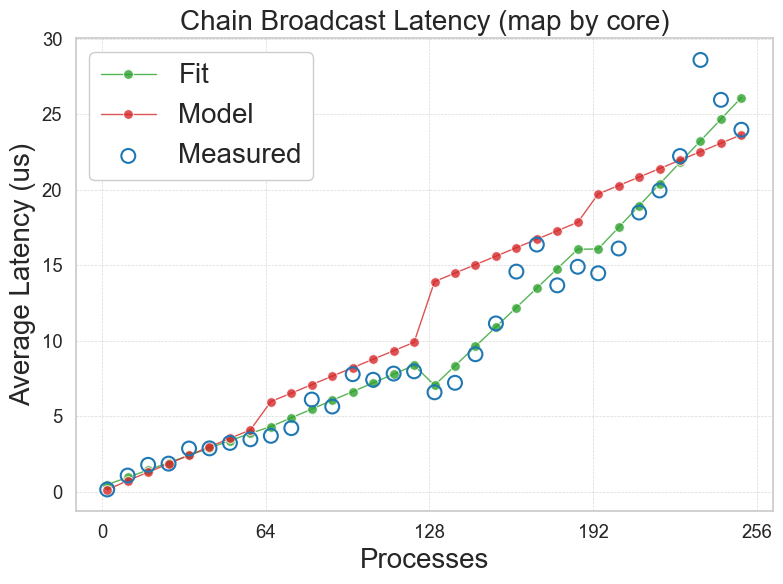

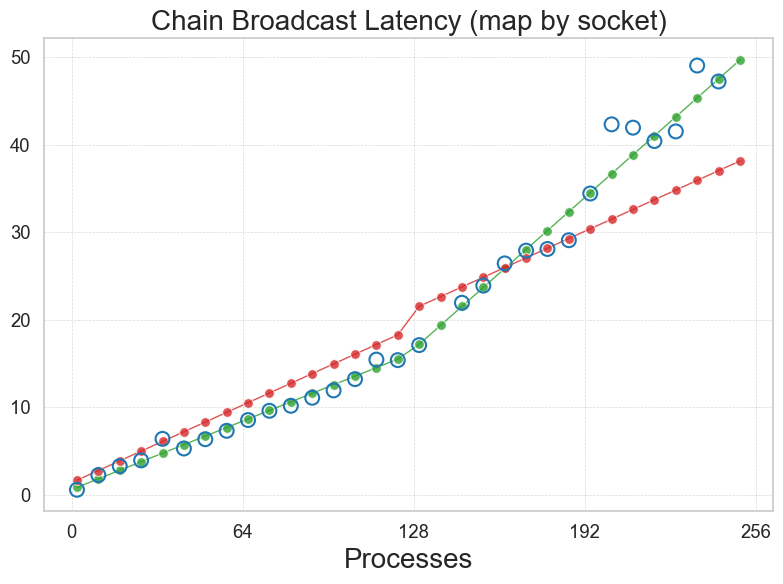

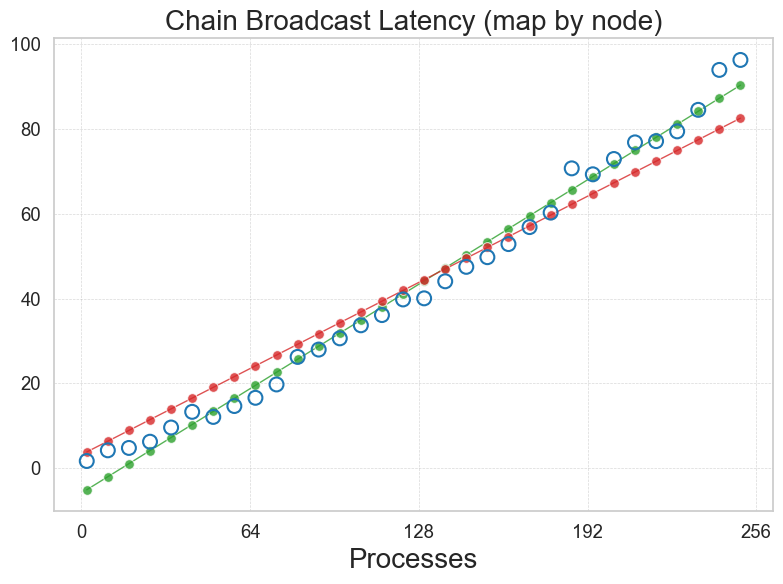

In [16]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65

# R2 ---------------------------------------------------------------------------

# Compute the R^2 for the Model
# Core
x = dfc2['cores']
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [chain_bcast(p[:core], sizestop, segments=5) for core in x]
r_squared = compute_r_squared(y_m, dfc2['latency'])
print(f"R-squared for core: {r_squared}")

# Socket
x = dfs2['cores']
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [chain_bcast(p[:core], sizestop, segments=12) for core in x]
r_squared = compute_r_squared(y_m, dfs2['latency'])
print(f"R-squared for socket: {r_squared}")

# Node
x = dfn2['cores']
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [chain_bcast(p[:core], sizestop, segments=12) for core in x]
r_squared = compute_r_squared(y_m, dfn2['latency'])
print(f"R-squared for node: {r_squared}")

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")

# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [chain_bcast(p[:core], sizestop, segments=5) for core in x]
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc2 = dfc2[dfc2['cores'].isin(x)]
dfc2 = dfc2.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:red', alpha =0.8)
plt.scatter(x=dfc2['cores'], y=dfc2['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Chain Broadcast Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-chain-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [chain_bcast(p[:core], sizestop, segments=12) for core in x]
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs2 = dfs2[dfs2['cores'].isin(x)]
dfs2 = dfs2.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfs2['cores'], y=dfs2['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Chain Broadcast Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-chain-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [chain_bcast(p[:core], sizestop, segments=12) for core in x]
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn2 = dfn2[dfn2['cores'].isin(x)]
dfn2 = dfn2.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfn2['cores'], y=dfn2['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Chain Broadcast Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-chain-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Binary Tree

In [18]:
# Loading datasets -------------------------------------------------------------
from numpy import log1p


dfn5 = preproc(node_file, 'node', 5)
dfs5 = preproc(socket_file, 'socket', 5)
dfc5 = preproc(core_file, 'core', 5)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn5 = dfn5[dfn5['size']==sizestop]
dfs5 = dfs5[dfs5['size']==sizestop]
dfc5 = dfc5[dfc5['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs5 = dfs5[~((dfs5['size']<=64) & (dfs5['latency']>50))]

# Add dummy variables ----------------------------------------------------------

# Add a log2(cores) column
dfc5['log2_cores'] = np.log2(dfc5['cores'])
dfs5['log2_cores'] = np.log2(dfs5['cores'])
dfn5['log2_cores'] = np.log2(dfn5['cores'])

# Core dataset
dfc5['group'] = pd.cut(dfc5['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc5['group'] = dfc5['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc5['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc5 = pd.concat([dfc5, group_dummies], axis=1)

# Create interaction terms with the cores
dfc5['cores_group2'] = dfc5['log2_cores'] * dfc5['group_socket2']
dfc5['cores_group3'] = dfc5['cores'] * dfc5['group_socket3']
dfc5['cores_group4'] = dfc5['cores'] * dfc5['group_socket4']

# Socket dataset
dfs5['group'] = pd.cut(dfs5['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs5['group'] = dfs5['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs5['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs5 = pd.concat([dfs5, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs5['cores_group1'] = dfs5['cores'] * dfs5['group_node1']
dfs5['cores_group2'] = dfs5['cores'] * dfs5['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc5['latency']
X = dfc5[['cores', 'log2_cores',
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs5['latency']
X = dfs5[['log2_cores', 'cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn5['latency']
X = dfn5[['log2_cores', 'cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    logp = np.log2(p)
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['log2_cores']*logp +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['log2_cores'] + beta['core']['cores_group2']) * logp +
                   (beta['core']['cores']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p +
                   (beta['core']['log2_cores']) * logp)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p +
                   (beta['core']['log2_cores']) * logp)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores'] * p +
                    beta['socket']['log2_cores'] * logp)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p +
                   (beta['socket']['log2_cores']) * logp)
    else:
        return (beta['node']['const'] + beta['node']['log2_cores'] * logp +
                beta['node']['cores'] * p)

R-squared for core: 0.5341764239595354
R-squared for socket: 0.32179343169856855
R-squared for node: 0.42113233505023184
R-squared for core: 0.9760498097832349
R-squared for socket: 0.9562346713461507
R-squared for node: 0.8914024489455521


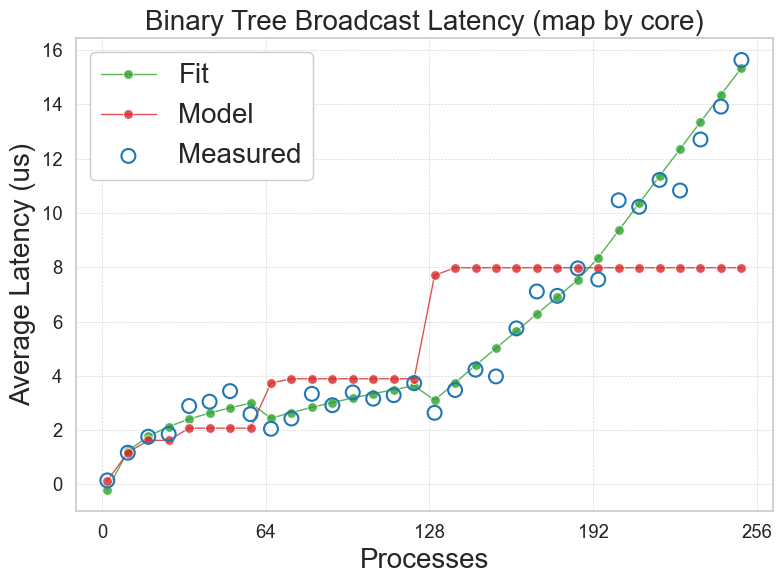

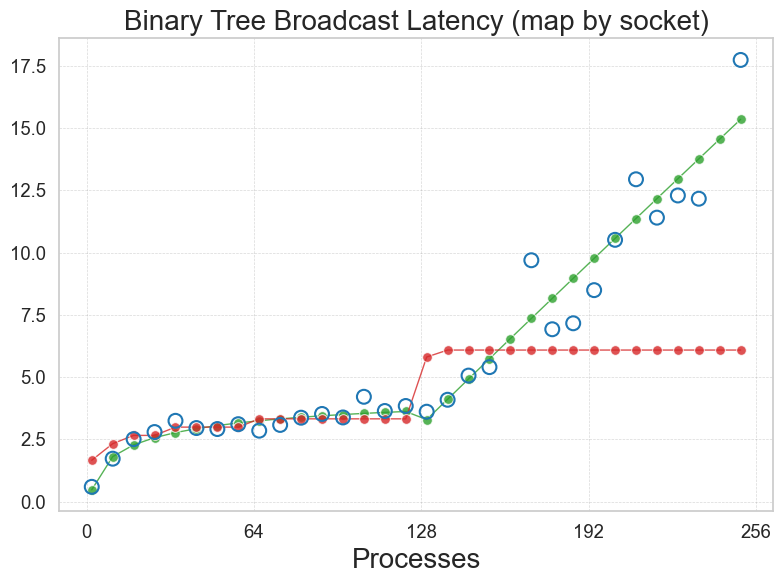

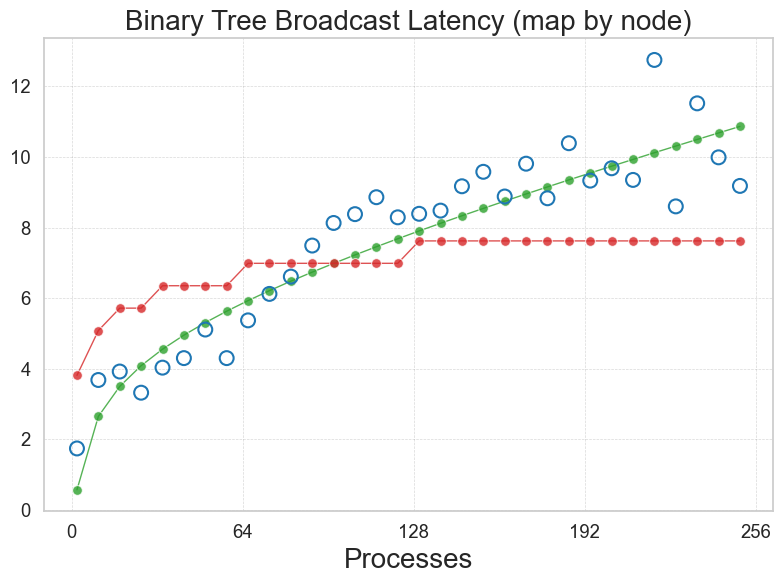

In [25]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65

# R2 ---------------------------------------------------------------------------

# Compute the R^2 for the Model
# Core
x = dfc5['cores']
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [binary_bcast(p[:core], sizestop, segments=1) for core in x]
r_squared = compute_r_squared(y_m, dfc5['latency'])
print(f"R-squared for core: {r_squared}")

# Socket
x = dfs5['cores']
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [binary_bcast(p[:core], sizestop, segments=5) for core in x]
r_squared = compute_r_squared(y_m, dfs5['latency'])
print(f"R-squared for socket: {r_squared}")

# Node
x = dfn5['cores']
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [binary_bcast(p[:core], sizestop, segments=6) for core in x]
r_squared = compute_r_squared(y_m, dfn5['latency'])
print(f"R-squared for node: {r_squared}")

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")

# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [binary_bcast(p[:core], sizestop, segments=1) for core in x]
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc5 = dfc5[dfc5['cores'].isin(x)]
dfc5 = dfc5.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:red', alpha =0.8)
plt.scatter(x=dfc5['cores'], y=dfc5['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Binary Tree Broadcast Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-binary-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [binary_bcast(p[:core], sizestop, segments=5) for core in x]
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs5 = dfs5[dfs5['cores'].isin(x)]
dfs5 = dfs5.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfs5['cores'], y=dfs5['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Binary Tree Broadcast Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-binary-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [binary_bcast(p[:core], sizestop, segments=6) for core in x]
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn5 = dfn5[dfn5['cores'].isin(x)]
dfn5 = dfn5.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfn5['cores'], y=dfn5['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Binary Tree Broadcast Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("bcast-binary-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

***

# Reduce Graphs

In [31]:
# Uncomments if you did not execute the cells above and want these below to work

# Load modules
# from utils import *
# from epyc import *
# import matplotlib.pyplot as plt
# import seaborn as sns
# import statsmodels.api as sm
# import numpy as np
# import pandas as pd
# import os

# Current working directory
cwd = os.getcwd()

# Broadcast data
node_file = os.path.join(cwd, '../datasets/reduce_node.csv')
socket_file = os.path.join(cwd, '../datasets/reduce_socket.csv')
core_file = os.path.join(cwd, '../datasets/reduce_core.csv')

# Create the node objects
# node1 = Node()
# node2 = Node()

## Default

In [32]:
# Loading datasets -------------------------------------------------------------
dfn0 = preproc(node_file, 'node', 0)
dfs0 = preproc(socket_file, 'socket', 0)
dfc0 = preproc(core_file, 'core', 0)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn0 = dfn0[dfn0['size']==sizestop]
dfs0 = dfs0[dfs0['size']==sizestop]
dfc0 = dfc0[dfc0['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs0 = dfs0[~((dfs0['size']<=64) & (dfs0['latency']>10))]

# Add dummy variables ----------------------------------------------------------

# Core dataset
dfc0['group'] = pd.cut(dfc0['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc0['group'] = dfc0['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc0['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc0 = pd.concat([dfc0, group_dummies], axis=1)

# Create interaction terms with the cores
dfc0['cores_group2'] = dfc0['cores'] * dfc0['group_socket2']
dfc0['cores_group3'] = dfc0['cores'] * dfc0['group_socket3']
dfc0['cores_group4'] = dfc0['cores'] * dfc0['group_socket4']

# Socket dataset
dfs0['group'] = pd.cut(dfs0['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs0['group'] = dfs0['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs0['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs0 = pd.concat([dfs0, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs0['cores_group1'] = dfs0['cores'] * dfs0['group_node1']
dfs0['cores_group2'] = dfs0['cores'] * dfs0['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc0['latency']
X = dfc0[['cores', 
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs0['latency']
X = dfs0[['cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn0['latency']
X = dfn0[['cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['cores'] + beta['core']['cores_group2']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores']*p)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p)
    else:
        return (beta['node']['const'] + beta['node']['cores'] * p)

R-squared for core: 0.8935340236627066
R-squared for socket: 0.8770598605412944
R-squared for node: 0.9128637020269251


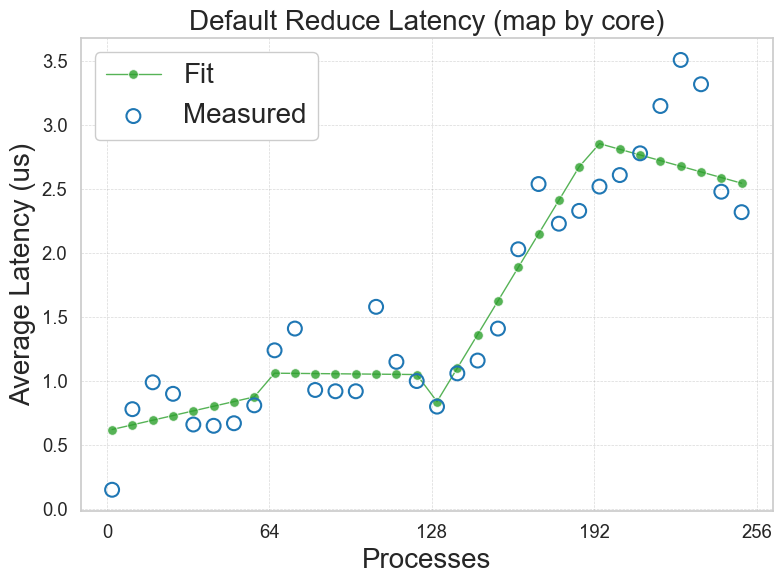

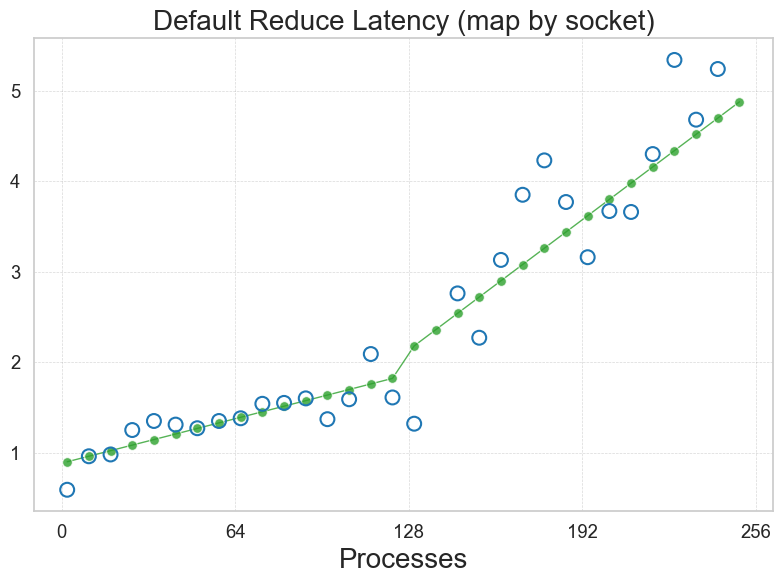

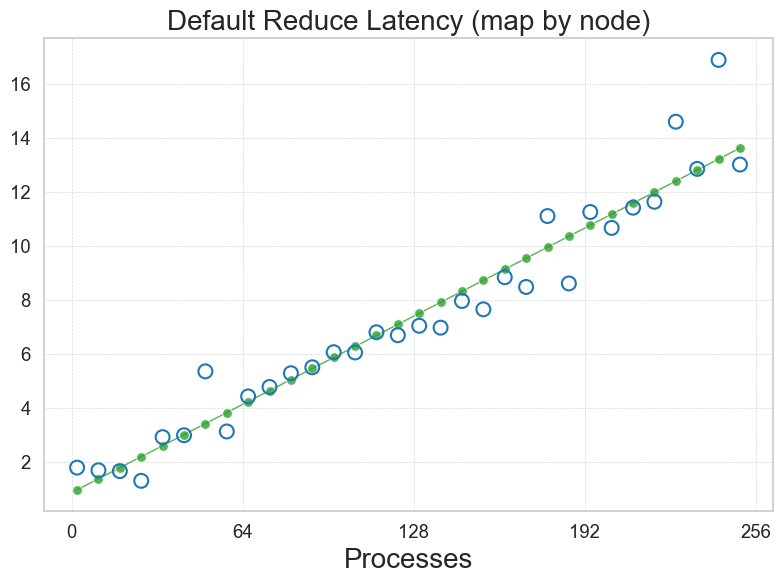

In [33]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65


# Compute the R^2 for the Model

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")

# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc0 = dfc0[dfc0['cores'].isin(x)]
dfc0 = dfc0.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
plt.scatter(x=dfc0['cores'], y=dfc0['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Default Reduce Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-default-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs0 = dfs0[dfs0['cores'].isin(x)]
dfs0 = dfs0.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
plt.scatter(x=dfs0['cores'], y=dfs0['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Default Reduce Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-default-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn0 = dfn0[dfn0['cores'].isin(x)]
dfn0 = dfn0.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
plt.scatter(x=dfn0['cores'], y=dfn0['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Default Reduce Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-default-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Linear

In [34]:
# Loading datasets -------------------------------------------------------------
dfn1 = preproc(node_file, 'node', 1)
dfs1 = preproc(socket_file, 'socket', 1)
dfc1 = preproc(core_file, 'core', 1)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn1 = dfn1[dfn1['size']==sizestop]
dfs1 = dfs1[dfs1['size']==sizestop]
dfc1 = dfc1[dfc1['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs1 = dfs1[~((dfs1['size']<=64) & (dfs1['latency']>10))]

# Add dummy variables ----------------------------------------------------------

# Core dataset
dfc1['group'] = pd.cut(dfc1['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc1['group'] = dfc1['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc1['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc1 = pd.concat([dfc1, group_dummies], axis=1)

# Create interaction terms with the cores
dfc1['cores_group2'] = dfc1['cores'] * dfc1['group_socket2']
dfc1['cores_group3'] = dfc1['cores'] * dfc1['group_socket3']
dfc1['cores_group4'] = dfc1['cores'] * dfc1['group_socket4']

# Socket dataset
dfs1['group'] = pd.cut(dfs1['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs1['group'] = dfs1['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs1['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs1 = pd.concat([dfs1, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs1['cores_group1'] = dfs1['cores'] * dfs1['group_node1']
dfs1['cores_group2'] = dfs1['cores'] * dfs1['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc1['latency']
X = dfc1[['cores', 
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs1['latency']
X = dfs1[['cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn1['latency']
X = dfn1[['cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['cores'] + beta['core']['cores_group2']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores']*p)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p)
    else:
        return (beta['node']['const'] + beta['node']['cores'] * p)

R-squared for core: -1.000175678173381
R-squared for socket: -1.1143637304305094
R-squared for node: -4.083270184584349
R-squared for core: 0.9884705973558122
R-squared for socket: 0.8822461042413627
R-squared for node: 0.9407836763574133


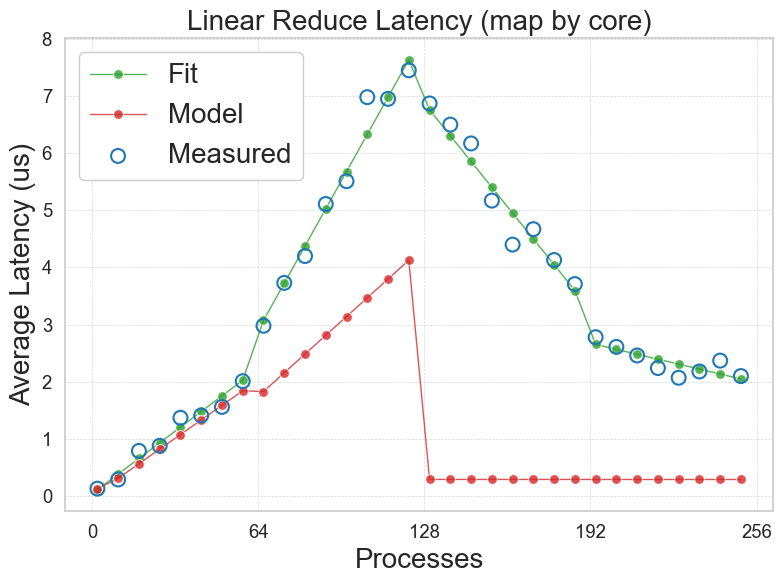

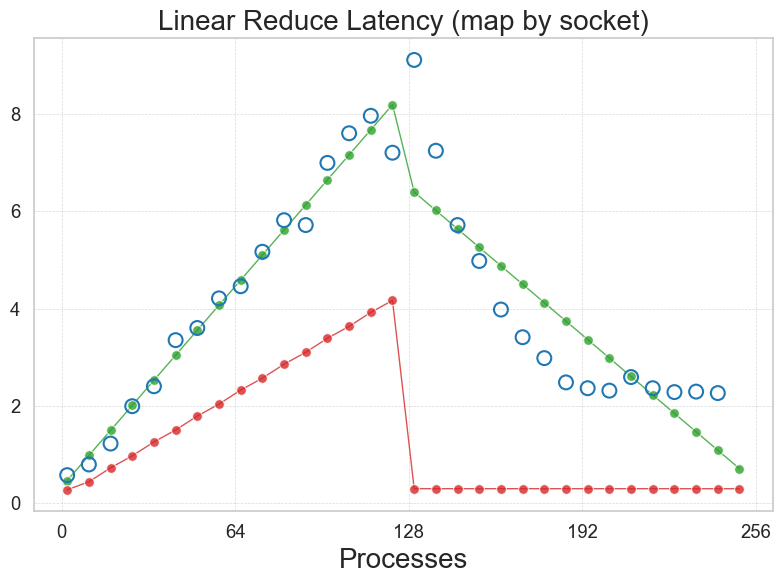

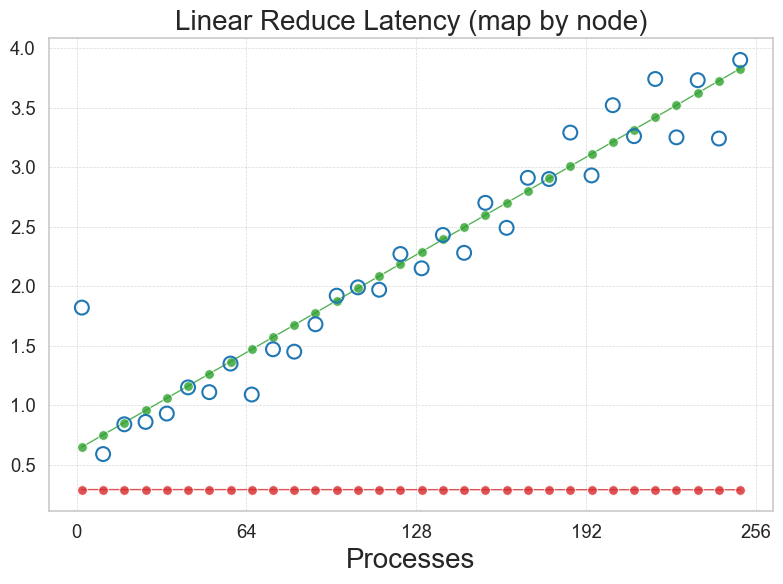

In [35]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65


# Compute the R^2 for the Model
# Core
x = dfc1['cores']
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [linear_reduce(p[:core], sizestop) for core in x]
r_squared = compute_r_squared(y_m, dfc1['latency'])
print(f"R-squared for core: {r_squared}")

# Socket
x = dfs1['cores']
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [linear_reduce(p[:core], sizestop) for core in x]
r_squared = compute_r_squared(y_m, dfs1['latency'])
print(f"R-squared for socket: {r_squared}")

# Node
x = dfn1['cores']
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [linear_reduce(p[:core], sizestop) for core in x]
r_squared = compute_r_squared(y_m, dfn1['latency'])
print(f"R-squared for node: {r_squared}")

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")

# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [linear_reduce(p[:core], sizestop) for core in x]
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc1 = dfc1[dfc1['cores'].isin(x)]
dfc1 = dfc1.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:red', alpha =0.8)
plt.scatter(x=dfc1['cores'], y=dfc1['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Reduce Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-linear-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [linear_reduce(p[:core], sizestop) for core in x]
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs1 = dfs1[dfs1['cores'].isin(x)]
dfs1 = dfs1.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfs1['cores'], y=dfs1['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Reduce Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-linear-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [linear_reduce(p[:core], sizestop) for core in x]
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn1 = dfn1[dfn1['cores'].isin(x)]
dfn1 = dfn1.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfn1['cores'], y=dfn1['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Reduce Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-linear-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Chain

In [36]:
# Loading datasets -------------------------------------------------------------
dfn2 = preproc(node_file, 'node', 2)
dfs2 = preproc(socket_file, 'socket', 2)
dfc2 = preproc(core_file, 'core', 2)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn2 = dfn2[dfn2['size']==sizestop]
dfs2 = dfs2[dfs2['size']==sizestop]
dfc2 = dfc2[dfc2['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs2 = dfs2[~((dfs2['size']<=64) & (dfs2['latency']>60))]

# Add dummy variables ----------------------------------------------------------

# Core dataset
dfc2['group'] = pd.cut(dfc2['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc2['group'] = dfc2['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc2['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc2 = pd.concat([dfc2, group_dummies], axis=1)

# Create interaction terms with the cores
dfc2['cores_group2'] = dfc2['cores'] * dfc2['group_socket2']
dfc2['cores_group3'] = dfc2['cores'] * dfc2['group_socket3']
dfc2['cores_group4'] = dfc2['cores'] * dfc2['group_socket4']

# Socket dataset
dfs2['group'] = pd.cut(dfs2['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs2['group'] = dfs2['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs2['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs2 = pd.concat([dfs2, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs2['cores_group1'] = dfs2['cores'] * dfs2['group_node1']
dfs2['cores_group2'] = dfs2['cores'] * dfs2['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc2['latency']
X = dfc2[['cores', 
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs2['latency']
X = dfs2[['cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn2['latency']
X = dfn2[['cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['cores'] + beta['core']['cores_group2']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores']*p)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p)
    else:
        return (beta['node']['const'] + beta['node']['cores'] * p)

R-squared for core: 0.7377752949413758
R-squared for socket: 0.8819727363696815
R-squared for node: 0.8090031494549242
R-squared for core: 0.9521700143990054
R-squared for socket: 0.9664095870679239
R-squared for node: 0.9768431684262899


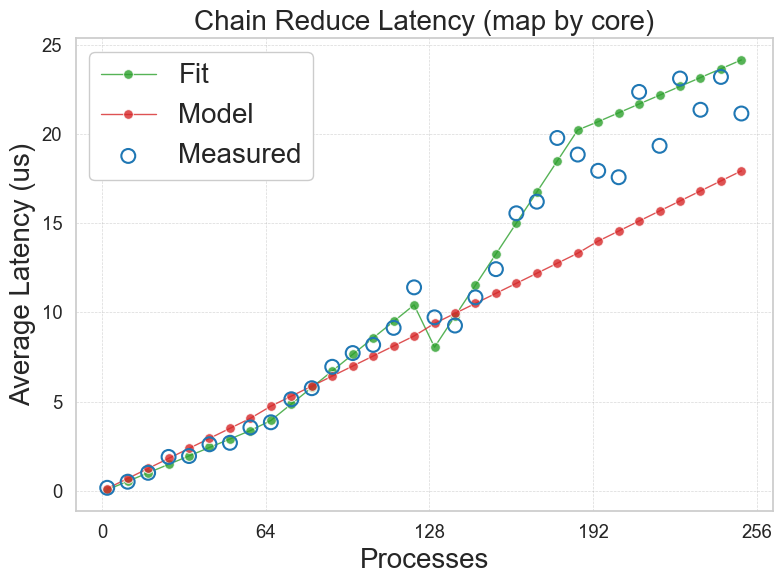

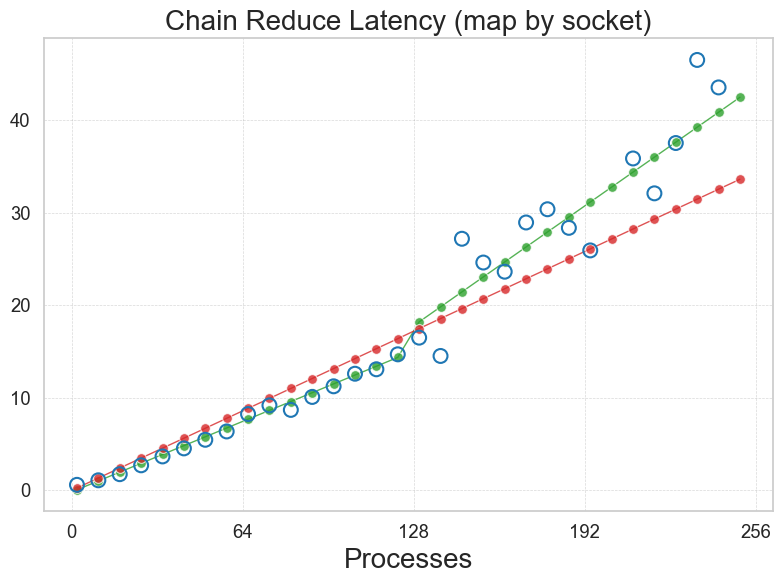

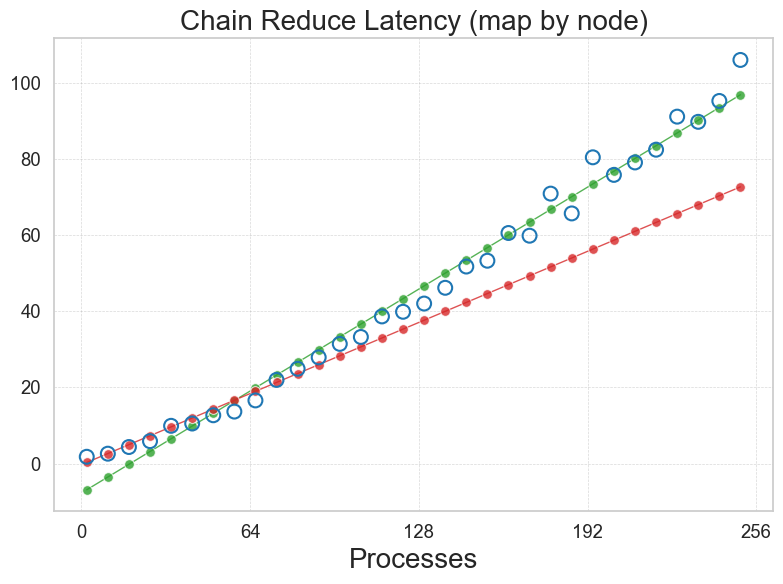

In [37]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65

# Compute the R^2 for the Model
# Core
x = dfc2['cores']
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [chain_reduce(p[:core], sizestop, segments=2) for core in x]
r_squared = compute_r_squared(y_m, dfc2['latency'])
print(f"R-squared for core: {r_squared}")

# Socket
x = dfs2['cores']
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [chain_reduce(p[:core], sizestop, segments=2) for core in x]
r_squared = compute_r_squared(y_m, dfs2['latency'])
print(f"R-squared for socket: {r_squared}")

# Node
x = dfn2['cores']
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [chain_reduce(p[:core], sizestop, segments=1) for core in x]
r_squared = compute_r_squared(y_m, dfn2['latency'])
print(f"R-squared for node: {r_squared}")

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")


# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [chain_reduce(p[:core], sizestop, segments=2) for core in x]
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc2 = dfc2[dfc2['cores'].isin(x)]
dfc2 = dfc2.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:red', alpha =0.8)
plt.scatter(x=dfc2['cores'], y=dfc2['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Chain Reduce Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-chain-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [chain_reduce(p[:core], sizestop, segments=2) for core in x]
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs2 = dfs2[dfs2['cores'].isin(x)]
dfs2 = dfs2.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfs2['cores'], y=dfs2['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Chain Reduce Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-chain-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [chain_reduce(p[:core], sizestop, segments=1) for core in x]
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn2 = dfn2[dfn2['cores'].isin(x)]
dfn2 = dfn2.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfn2['cores'], y=dfn2['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Chain Reduce Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-chain-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Binary Tree

In [47]:
# Loading datasets -------------------------------------------------------------
from numpy import log1p


dfn5 = preproc(node_file, 'node', 4)
dfs5 = preproc(socket_file, 'socket', 4)
dfc5 = preproc(core_file, 'core', 4)

# Filter size ------------------------------------------------------------------
sizestop = 2**0
dfn5 = dfn5[dfn5['size']==sizestop]
dfs5 = dfs5[dfs5['size']==sizestop]
dfc5 = dfc5[dfc5['size']==sizestop]

# Cleaning datasets ------------------------------------------------------------
dfs5 = dfs5[~((dfs5['size']<=64) & (dfs5['latency']>20))]
dfn5 = dfn5[~((dfn5['size']<=64) & (dfn5['latency']>2.5))]

# Add dummy variables ----------------------------------------------------------

# Add a log2(cores) column
dfc5['log2_cores'] = np.log2(dfc5['cores'])
dfs5['log2_cores'] = np.log2(dfs5['cores'])
dfn5['log2_cores'] = np.log2(dfn5['cores'])

# Core dataset
dfc5['group'] = pd.cut(dfc5['cores'],
                       bins=[0, 64, 128, 192, 256], 
                       labels=['socket1', 'socket2', 'socket3', 'socket4'])
dfc5['group'] = dfc5['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfc5['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfc5 = pd.concat([dfc5, group_dummies], axis=1)

# Create interaction terms with the cores
dfc5['cores_group2'] = dfc5['log2_cores'] * dfc5['group_socket2']
dfc5['cores_group3'] = dfc5['cores'] * dfc5['group_socket3']
dfc5['cores_group4'] = dfc5['cores'] * dfc5['group_socket4']

# Socket dataset
dfs5['group'] = pd.cut(dfs5['cores'], 
                       bins=[0, 128, 256], 
                       labels=['node1', 'node2'])
dfs5['group'] = dfs5['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(dfs5['group'], 
                               prefix='group', 
                               drop_first=True).astype(int)
dfs5 = pd.concat([dfs5, group_dummies], axis=1)

# Create interaction terms with the cores
# dfs5['cores_group1'] = dfs5['cores'] * dfs5['group_node1']
dfs5['cores_group2'] = dfs5['cores'] * dfs5['group_node2']


# Node dataset
# Node mapping does not need any additional categorical variable...


# Linear Fits ------------------------------------------------------------------

# Dictionary to store the parameters of the fits
beta = {'core' : [], 'socket' : [], 'node' : []}

# Core fit
y = dfc5['latency']
X = dfc5[['cores', 'log2_cores',
          'group_socket2', 'cores_group2', 
          'group_socket3', 'cores_group3', 
          'group_socket4', 'cores_group4']]
X = sm.add_constant(X)
model_core = sm.OLS(y, X)
fit_core = model_core.fit()
beta['core'] = (fit_core.params)

# Socket fit
y = dfs5['latency']
X = dfs5[['log2_cores', 'cores', 'group_node2', 'cores_group2']]
X = sm.add_constant(X)
model_socket = sm.OLS(y, X)
fit_socket = model_socket.fit()
beta['socket'] = (fit_socket.params)

# Node fit
y = dfn5['latency']
X = dfn5[['log2_cores', 'cores']]
X = sm.add_constant(X)
model_node = sm.OLS(y, X)
fit_node = model_node.fit()
beta['node'] = (fit_node.params)

# Fit function
def linear_fit(p, mapby: str):
    logp = np.log2(p)
    if mapby == 'core':
        if p <= 64:
            return (beta['core']['const'] +
                    beta['core']['log2_cores']*logp +
                    beta['core']['cores']*p)
        elif p>64 and p<=128:
            return (beta['core']['const'] + beta['core']['group_socket2'] +
                   (beta['core']['log2_cores'] + beta['core']['cores_group2']) * logp +
                   (beta['core']['cores']) * p)
        elif p>128 and p<=192:
            return (beta['core']['const'] + beta['core']['group_socket3'] +
                   (beta['core']['cores'] + beta['core']['cores_group3']) * p +
                   (beta['core']['log2_cores']) * logp)
        else:
            return (beta['core']['const'] + beta['core']['group_socket4'] +
                   (beta['core']['cores'] + beta['core']['cores_group4']) * p +
                   (beta['core']['log2_cores']) * logp)
    elif mapby == 'socket':
        if p <= 128:
            return (beta['socket']['const'] +
                    beta['socket']['cores'] * p +
                    beta['socket']['log2_cores'] * logp)
        else:
            return (beta['socket']['const'] + beta['socket']['group_node2'] +
                   (beta['socket']['cores'] + beta['socket']['cores_group2']) * p +
                   (beta['socket']['log2_cores']) * logp)
    else:
        return (beta['node']['const'] + beta['node']['log2_cores'] * logp +
                beta['node']['cores'] * p)

R-squared for core: 0.39494823373325383
R-squared for socket: -0.039795533184731724
R-squared for node: -12.531997921902708
R-squared for core: 0.9873733612070359
R-squared for socket: 0.9610101757787568
R-squared for node: 0.3633602331154602


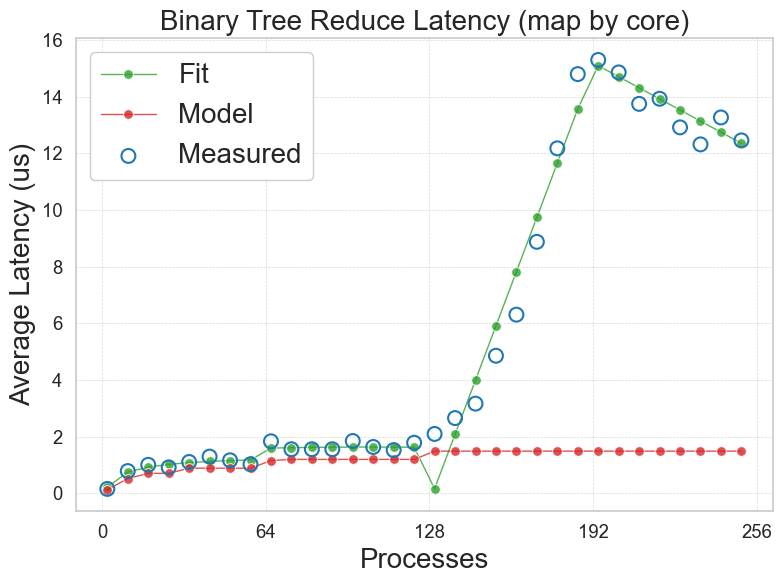

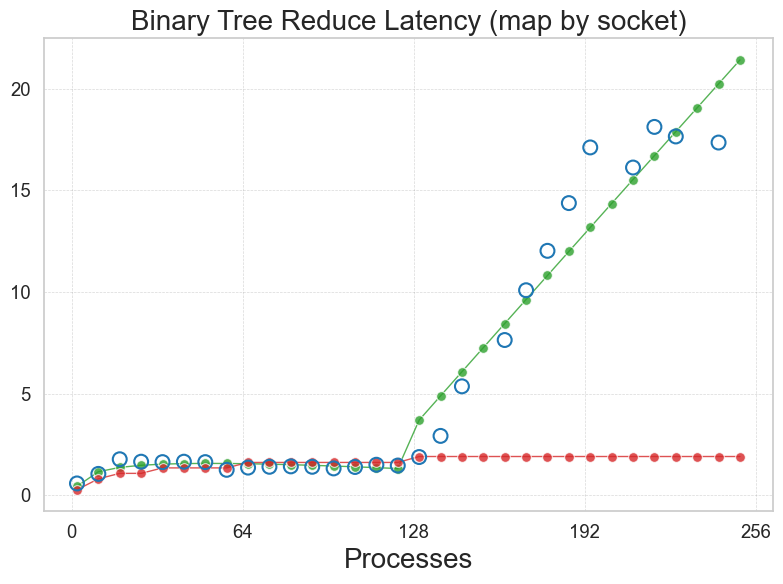

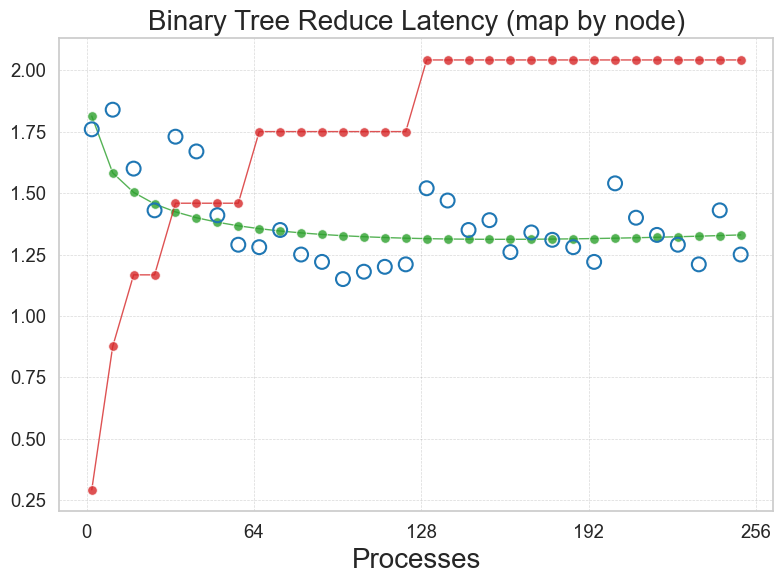

In [49]:
# Plotting ---------------------------------------------------------------------

# Genral plot settings
fontsize = 20
width = 8
height = 6
x_ticks = [0, 64, 128, 192, 256]
ymin=-1
ymax=65

# Compute the R^2 for the Model
# Core
x = dfc5[dfc5['cores']<=64]['cores']
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [binary_reduce(p[:core], sizestop, segments=1) for core in x]
r_squared = compute_r_squared(y_m, dfc5[dfc5['cores']<=64]['latency'])
print(f"R-squared for core: {r_squared}")

# Socket
x = dfs5[dfs5['cores']<=64]['cores']
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [binary_reduce(p[:core], sizestop, segments=1) for core in x]
r_squared = compute_r_squared(y_m, dfs5[dfs5['cores']<=64]['latency'])
print(f"R-squared for socket: {r_squared}")

# Node
x = dfn5['cores']
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [binary_reduce(p[:core], sizestop, segments=1) for core in x]
r_squared = compute_r_squared(y_m, dfn5['latency'])
print(f"R-squared for node: {r_squared}")

# Print the R^2 of the fits for comparison
print(f"R-squared for core: {fit_core.rsquared}")
print(f"R-squared for socket: {fit_socket.rsquared}")
print(f"R-squared for node: {fit_node.rsquared}")


# Core -------------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [binary_reduce(p[:core], sizestop, segments=1) for core in x]
y_f = [linear_fit(p, mapby='core') for p in x]

# Filter the original dataset
dfc5 = dfc5[dfc5['cores'].isin(x)]
dfc5 = dfc5.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', 
             linewidth=1, marker='o', markersize=7, 
             color='tab:red', alpha =0.8)
plt.scatter(x=dfc5['cores'], y=dfc5['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Binary Tree Reduce Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-binary-core.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Socket -----------------------------------------------------------------------

# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [binary_reduce(p[:core], sizestop, segments=1) for core in x]
y_f = [linear_fit(p, mapby='socket') for p in x]

# Filter the original dataset
dfs5 = dfs5[dfs5['cores'].isin(x)]
dfs5 = dfs5.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfs5['cores'], y=dfs5['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Binary Tree Reduce Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-binary-socket.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Node -------------------------------------------------------------------------
# Compute Fit and Model points
x = np.arange(2, 256, 8)
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [binary_reduce(p[:core], sizestop, segments=1) for core in x]
y_f = [linear_fit(p, mapby='node') for p in x]

# Filter the original dataset
dfn5 = dfn5[dfn5['cores'].isin(x)]
dfn5 = dfn5.groupby('cores')['latency'].mean().reset_index()

# Plot
plt.figure(figsize=(width,height))
sns.set_theme(style="whitegrid", palette="tab10", 
              rc={"grid.linestyle": "--", 
                  "grid.color": "gray", 
                  "grid.alpha": 0.3, 
                  "grid.linewidth": 0.5})

sns.lineplot(x=x, y=y_f, label='Fit',
            linewidth=1, marker='o', markersize=7, 
            color='tab:green', alpha =0.8,
            legend=False)
sns.lineplot(x=x, y=y_m, label='Model',
            linewidth=1, marker='o', markersize=7, 
            color='tab:red', alpha =0.8,
            legend=False)
plt.scatter(x=dfn5['cores'], y=dfn5['latency'], label = 'Measured',
            linewidth=1.5, marker='o', s=100, 
            edgecolors='tab:blue', alpha = 1, 
            facecolors='none', zorder=10)

# Labels
# plt.ylim(ymin, ymax)
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Binary Tree Reduce Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()

# Save the image as high quality pdf
plt.savefig("reduce-binary-node.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()